## Regional Analysis

In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio
import climate_indices
import spei
import fsspec
import netCDF4
import h5py
from rasterio.plot import show

In [53]:
def plot_time_series(mask, var_ds, var_name, y_label, x_label1,x_title1, x_label2,x_title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    region_1 = var_ds.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = var_ds.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = var_ds.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    x = var_ds.time

    ax1.plot(x, region_3, marker='o', label="Frankenwald", color="#fde725")
    ax1.plot(x, region_2, marker='o', label="Thüringer Schiefergebirge", color="#21918c")
    ax1.plot(x, region_1, marker='o', label="Thüringer Wald", color="#440154")
    ax1.set_xlabel(x_label1)
    ax1.set_ylabel(y_label)
    ax1.set_title(x_title1)
    ax1.legend()

    summer_months = var_ds.sel(time=var_ds.time.dt.month.isin([6,7])).resample(time="Y").mean()
    region_1 = summer_months.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = summer_months.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = summer_months.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))

    x=summer_months.time
    ax2.plot(x, region_3, marker='o', label="Frankenwald", color="#fde725")
    ax2.plot(x, region_2, marker='o', label="Thüringer Schiefergebirge", color="#21918c")
    ax2.plot(x, region_1, marker='o', label="Thüringer Wald", color="#440154")
    ax2.set_xlabel(x_label2)
    ax2.set_ylabel(y_label)
    ax2.set_title(x_title2)

#### Region masks



In [54]:
path = '/work/users/my982hzao/'
ds_CF_20 = xr.open_zarr(fsspec.get_mapper(path + 'Climate_variables/soil_moisture_masked.zarr/'),
                  consolidated=True)

mask = ds_CF_20["mask"]
mask = mask.rename({"lon": "x", "lat": "y"})
mask.rio.write_crs("EPSG:4326", inplace=True)
  

<xarray.DataArray 'mask' (y: 77, x: 120)>
dask.array<open_dataset-26c86e3d1ff609e6c77f10abe0ea7315mask, shape=(77, 120), dtype=float64, chunksize=(77, 120), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 51.0 50.99 50.98 50.97 ... 50.34 50.33 50.32 50.31
  * x            (x) float64 10.29 10.3 10.32 10.33 ... 11.96 11.97 11.99 12.0
    spatial_ref  int64 0

#### 1. Climate Indices 
##### a. Temperature

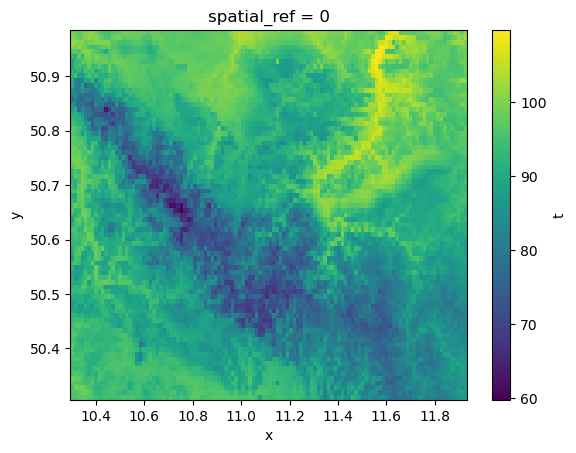

In [55]:
temp_ds = xr.open_zarr(fsspec.get_mapper(path + 'temperature_UTM.zarr/'), consolidated=True)
temp_ds
temp_utm = temp_ds
temp_utm=temp_utm.rename({"lon": "x", "lat": "y"})
temp_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected = mask.rio.reproject_match(temp_utm).rename({"x": "lon", "y": "lat"})

temp_utm.t.mean(dim='time').plot()

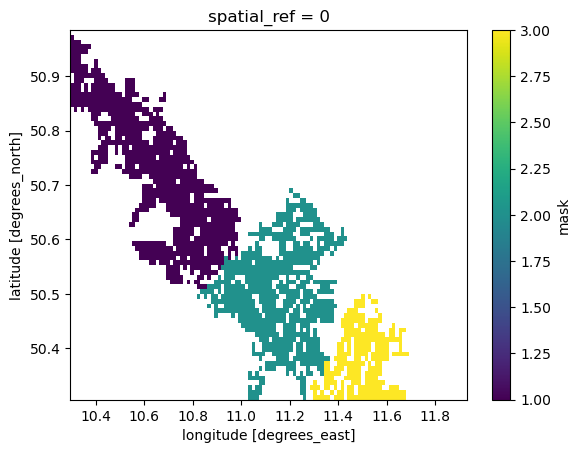

In [56]:
mask_reprojected.plot()

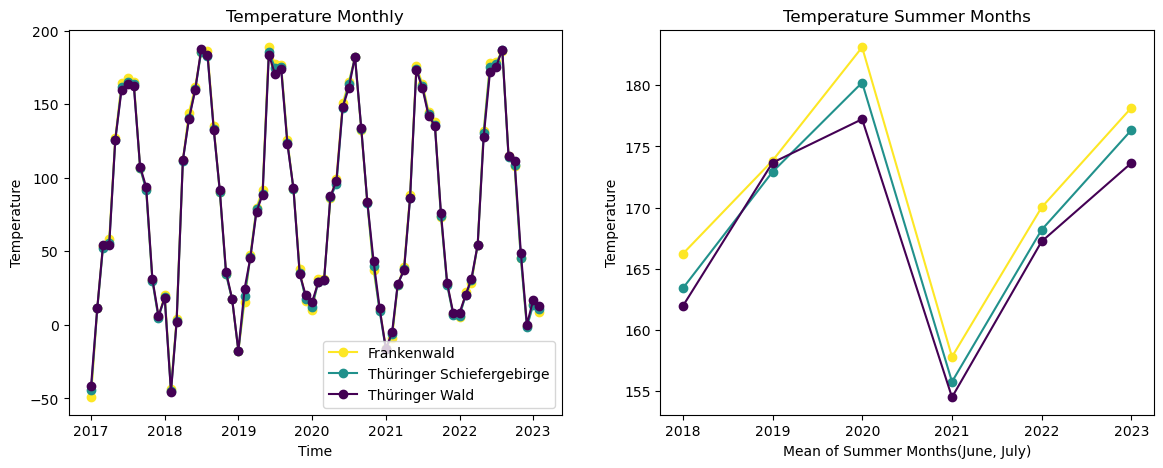

In [57]:
plot_time_series(mask_reprojected, temp_ds, "t", "Temperature","Time",'Temperature Monthly',"Mean of Summer Months(June, July)", 'Temperature Summer Months')

##### b. Soil Moisture

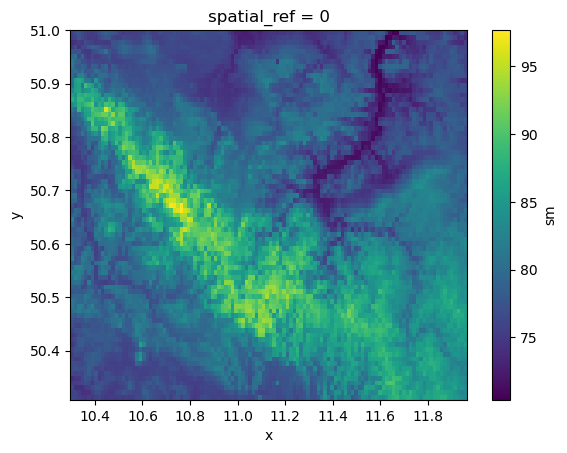

In [58]:
sm_ds = xr.open_zarr(fsspec.get_mapper(path + 'soil_moisture_monthly_UTM.zarr/'), consolidated=True)

sm_utm = sm_ds
sm_utm=sm_utm.rename({"lon": "x", "lat": "y"})
sm_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected = mask.rio.reproject_match(sm_utm).rename({"x": "lon", "y": "lat"})

sm_utm.sm.mean(dim='time').plot()

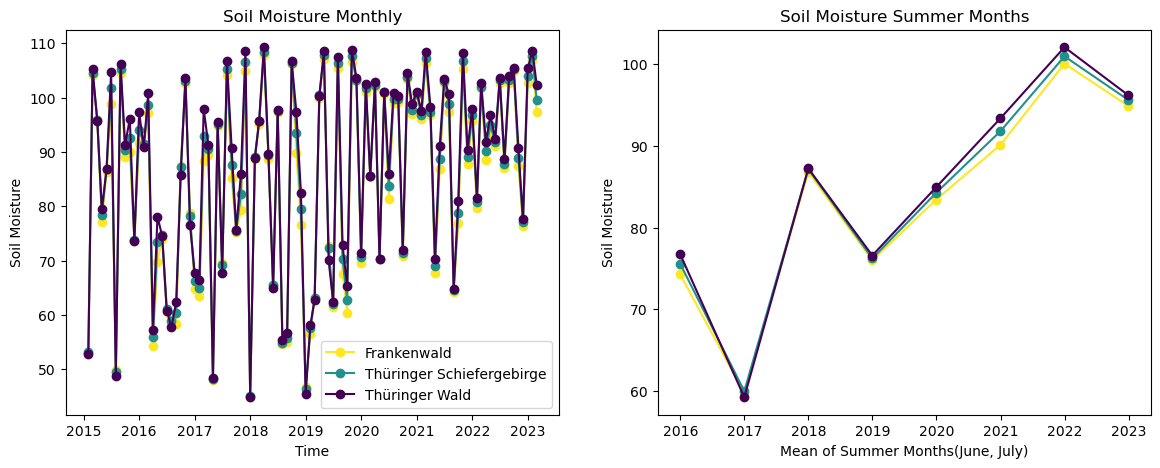

In [59]:
plot_time_series(mask_reprojected, sm_ds, "sm", "Soil Moisture","Time",'Soil Moisture Monthly',"Mean of Summer Months(June, July)", 'Soil Moisture Summer Months')


##### c. Precipitation 

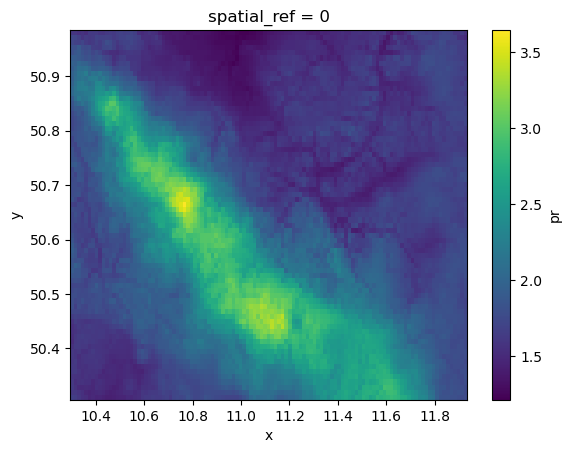

In [60]:
pr_ds = xr.open_zarr(fsspec.get_mapper(path + 'precipitation_UTM.zarr/'), consolidated=True)
pr_utm = pr_ds
pr_utm=pr_utm.rename({"lon": "x", "lat": "y"})
pr_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected = mask.rio.reproject_match(pr_utm).rename({"x": "lon", "y": "lat"})

pr_utm.pr.mean(dim='time').plot()

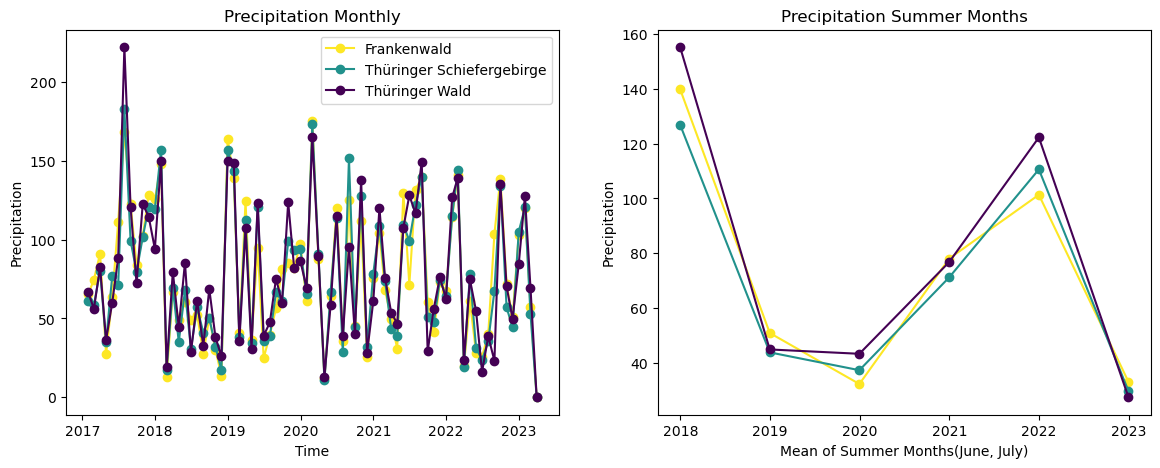

In [61]:
pr_ds_monthly = pr_ds.sortby('time').resample(time='1M').sum()
plot_time_series(mask_reprojected, pr_ds_monthly, "pr","Precipitation","Time",'Precipitation Monthly',"Mean of Summer Months(June, July)", 'Precipitation Summer Months')


In [62]:
pr_ds.sel(time=pr_ds.time.dt.month.isin([6,7]))

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 113, time: 366)
Coordinates:
  * lat      (lat) float64 50.31 50.32 50.33 50.34 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float64 10.3 10.32 10.33 10.35 ... 11.88 11.9 11.91 11.93
  * time     (time) datetime64[ns] 2018-06-01T18:00:00 ... 2019-07-31T18:00:00
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(108, 19, 29), meta=np.ndarray>

##### d. Evapotranspiration

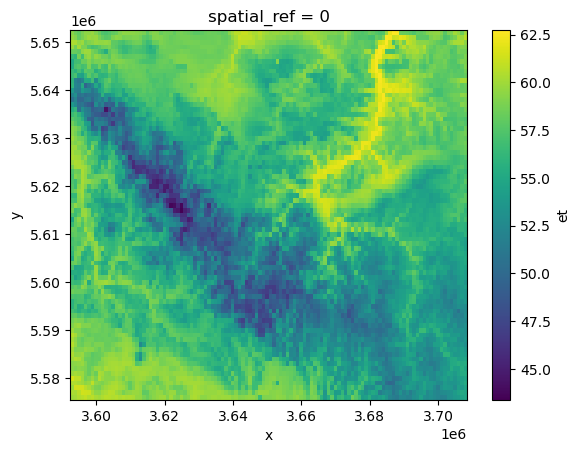

In [63]:
et_ds = xr.open_zarr(fsspec.get_mapper(path + 'evapotranspiration_UTM.zarr/'), consolidated=True)
et_utm = et_ds
et_utm=et_utm.rename({"lon": "x", "lat": "y"})
et_utm.rio.write_crs("EPSG:31467", inplace=True)
mask_reprojected = mask.rio.reproject_match(et_utm).rename({"x": "lon", "y": "lat"})

et_utm.et.mean(dim='time').plot()

In [64]:
et_utm

<xarray.Dataset>
Dimensions:      (time: 74, y: 77, x: 116)
Coordinates:
  * y            (y) float64 5.652e+06 5.651e+06 ... 5.577e+06 5.576e+06
  * x            (x) float64 3.593e+06 3.594e+06 ... 3.707e+06 3.708e+06
  * time         (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
    spatial_ref  int64 0
Data variables:
    et           (time, y, x) float64 dask.array<chunksize=(19, 39, 58), meta=np.ndarray>
Attributes:
    _FillValue:  nan
    units:       mm

In [65]:
pr_ds_monthly

<xarray.Dataset>
Dimensions:  (time: 75, lat: 73, lon: 113)
Coordinates:
  * lat      (lat) float64 50.31 50.32 50.33 50.34 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float64 10.3 10.32 10.33 10.35 ... 11.88 11.9 11.91 11.93
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-03-31
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(12, 19, 29), meta=np.ndarray>

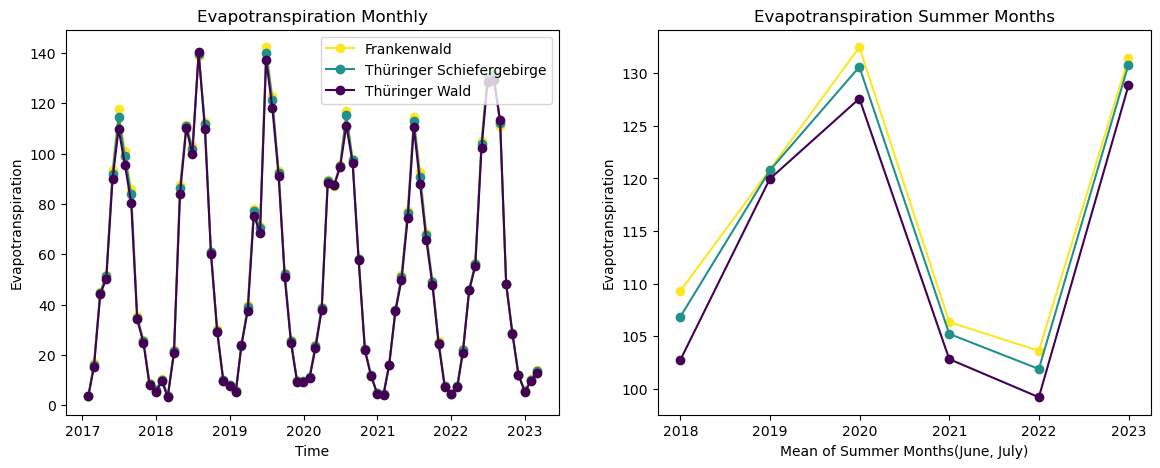

In [66]:
plot_time_series(mask_reprojected, et_utm.rename({"x": "lon", "y": "lat"}), "et","Evapotranspiration","Time",'Evapotranspiration Monthly',"Mean of Summer Months(June, July)", 'Evapotranspiration Summer Months')